In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import ParametricQuantumCircuit, QuantumCircuit, PauliOperator
from qulacs.gate import CZ, RY,RZ, merge, ParametricRY, ParametricRZ, PauliRotation
from qulacs import QuantumState, QuantumCircuit
from qulacs import DensityMatrix
from qulacs.gate import Probabilistic, Identity, X, Y, Z, T, DepolarizingNoise, RandomUnitary, P0, P1, add, merge, DephasingNoise
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import SWAP
from qulacs.gate import H, S, Sdag, CNOT, SWAP, RZ
from qulacs import QuantumCircuit, QuantumState
from qulacs.observable import create_observable_from_openfermion_text

In [2]:
def noisy_time_evolution(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        for n in range(n_qubit // 2):
            PauliRotation([2*n, 2*n+1], [1, 1], theta).update_quantum_state(rho)
            PauliRotation([2*n, 2*n+1], [2, 2], theta).update_quantum_state(rho)
            PauliRotation([2*n, 2*n+1], [3, 3], theta).update_quantum_state(rho)

        for n in range(n_qubit // 2 - 1):
            PauliRotation([2*n+1, 2*n+2], [1, 1], theta).update_quantum_state(rho)
            PauliRotation([2*n+1, 2*n+2], [2, 2], theta).update_quantum_state(rho)
            PauliRotation([2*n+1, 2*n+2], [3, 3], theta).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    return rho



def symmetry_verification(rho_input, n_qubit, layer, theta, p_err):
    p_err_gadget = p_err / 100
    rho = rho_input.copy()

    rho = noisy_time_evolution(rho, n_qubit, layer, theta, p_err)

    rho_ancilla = DensityMatrix(1)
    rho = tensor_product(rho_ancilla, rho)

    for n in range(n_qubit):
        CNOT(n, n_qubit).update_quantum_state(rho)
        DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
    DepolarizingNoise(n_qubit, p_err_gadget).update_quantum_state(rho)

    completely_mixed_state = DensityMatrix(n_qubit)
    completely_mixed_state.load(np.identity(2**n_qubit))
    projector = tensor_product(DensityMatrix(1), completely_mixed_state)
    if n_qubit % 4 == 2:
        X(n_qubit).update_quantum_state(projector)
    rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
    rho.load(rho_matrix)
    rho = partial_trace(rho, [n_qubit])

    return rho



def symmetric_channel_verification(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, with_ancilla_noise = True):
    p_err_gadget = p_err / 100
    layer_per_purification = layer // verification_frequensy
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(2)
        rho = tensor_product(rho_ancilla, rho)

        H(n_qubit).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        if with_ancilla_noise:
            DepolarizingNoise(n_qubit, p_err_gadget).update_quantum_state(rho)
            DepolarizingNoise(n_qubit+1, p_err_gadget).update_quantum_state(rho)

        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)
        H(n_qubit).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        if with_ancilla_noise:
            DepolarizingNoise(n_qubit, p_err_gadget).update_quantum_state(rho)
            DepolarizingNoise(n_qubit+1, p_err_gadget).update_quantum_state(rho)

        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(2), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit, n_qubit+1])

    return rho

In [ ]:
n_qubit = 8
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / 100

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit//2):
        X(2*n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel_layerwise = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel = rho_channel.get_matrix()
    rho_channel_layerwise = rho_channel_layerwise.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_list[p_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2
    tracedist_channel_layerwise_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise / np.trace(rho_channel_layerwise), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


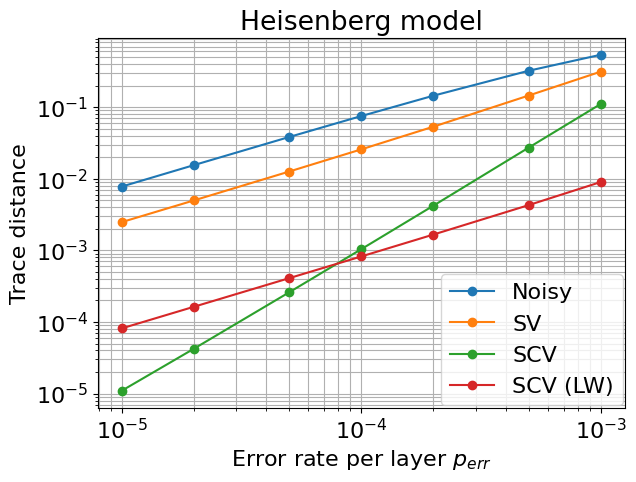

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Noisy')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o', label = 'SCV')
plt.plot(p_err_list, tracedist_channel_layerwise_list, marker = 'o', label = 'SCV (LW)')

plt.xscale('log')
plt.yscale('log')
plt.title('Heisenberg model')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('Heisenberg.pdf', bbox_inches='tight')